<a href="https://colab.research.google.com/github/EduardoAve/Data-science-portfolio/blob/main/bank-customer-churn/churn_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [22]:
# ==============================================================================
# 1. INTRODUCTION AND SETUP
# ==============================================================================

# ------------------------------------------------------------------------------
# 1.1. Problem Description and Objectives (Same as before)
# ------------------------------------------------------------------------------
# The objective of this project is to build a machine learning model capable
# of predicting which bank customers have a high probability of leaving
# their services (churn). Identifying these customers allows the bank to take
# proactive actions to retain them, which is usually more cost-effective than
# acquiring new customers.
#
# We will use a public dataset (originally from Kaggle) with demographic
# and behavioral information about the customers, uploaded manually.
#
# Specific Objectives:
# - Perform detailed exploratory data analysis (EDA) to understand the data.
# - Preprocess the data for modeling.
# - Handle class imbalance using appropriate techniques (e.g., SMOTE).
# - Train and evaluate multiple classification models.
# - Identify the most influential factors in the churn decision.
# - Interpret the results in a business context.

# ------------------------------------------------------------------------------
# 1.2. Library Imports (More comprehensive)
# ------------------------------------------------------------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
# Use regular Pipeline for now, switch to ImbPipeline later if imblearn is available
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score,
    roc_curve, precision_recall_curve, auc, accuracy_score
)

# Attempt to import imblearn components
try:
    from imblearn.over_sampling import SMOTE
    from imblearn.pipeline import Pipeline as ImbPipeline
    imblearn_available = True
    print("imbalanced-learn library found. SMOTE is available.")
except ImportError:
    print("Warning: imbalanced-learn is not installed. SMOTE will not be available.")
    print("You can install it with: pip install imbalanced-learn")
    # Fallback to regular Pipeline if imblearn is not available
    ImbPipeline = Pipeline # Use regular Pipeline as a fallback name
    imblearn_available = False

# Additional configurations
sns.set_style('whitegrid')
pd.set_option('display.max_columns', None)
warnings.filterwarnings('ignore')

print("\nLibraries imported.")


imbalanced-learn library found. SMOTE is available.

Libraries imported.


In [23]:

# ==============================================================================
# 2. DATA LOADING AND INITIAL EXPLORATION
# ==============================================================================

# ------------------------------------------------------------------------------
# 2.1. Data Loading (Manual Upload - File expected in /content/)
# ------------------------------------------------------------------------------
# --- Instructions ---
# This cell assumes you have ALREADY uploaded the
# 'Bank Customer Churn Prediction.csv' file to the Colab session
# using the "Files" panel on the left side.

try:
    # Define the filename directly (make sure it matches the uploaded file)
    file_name = 'Bank Customer Churn Prediction.csv'
    # Check if file exists before trying to read
    if os.path.exists(file_name):
        df = pd.read_csv(file_name)
        print(f"\nFile '{file_name}' found in /content/ and DataFrame loaded successfully.")

        # --- Print columns and head to verify ---
        print("\nActual columns found in the CSV:")
        print(df.columns.tolist())
        print("\nFirst 5 rows of the loaded data:")
        print(df.head())
        # --- END ---

        data_loaded = True
    else:
        print(f"\nError: File '{file_name}' not found in /content/.")
        print("Please upload it using the 'Files' panel on the left and run this cell again.")
        data_loaded = False

except Exception as e:
    print(f"\nAn error occurred loading the CSV: {e}")
    data_loaded = False

# ------------------------------------------------------------------------------
# 2.2. Initial Exploration (Basic info)
# ------------------------------------------------------------------------------
if data_loaded:
    print("\n--- General DataFrame Information ---")
    df.info()

    # print("\n--- Last 5 Rows ---") # Optional
    # print(df.tail())

    print("\n--- Dimensions (Rows, Columns) ---")
    print(df.shape)

    print("\n--- Statistical Summary (Numeric Variables) ---")
    print(df.describe())

    print("\n--- Summary (Categorical Variables) ---")
    print(df.describe(include=['object', 'category']))

    print("\n--- Null Value Counts per Column ---")
    print(df.isnull().sum())

else:
    print("\nSkipping Initial Exploration: Data not loaded.")




File 'Bank Customer Churn Prediction.csv' found in /content/ and DataFrame loaded successfully.

Actual columns found in the CSV:
['customer_id', 'credit_score', 'country', 'gender', 'age', 'tenure', 'balance', 'products_number', 'credit_card', 'active_member', 'estimated_salary', 'churn']

First 5 rows of the loaded data:
   customer_id  credit_score country  gender  age  tenure    balance  \
0     15634602           619  France  Female   42       2       0.00   
1     15647311           608   Spain  Female   41       1   83807.86   
2     15619304           502  France  Female   42       8  159660.80   
3     15701354           699  France  Female   39       1       0.00   
4     15737888           850   Spain  Female   43       2  125510.82   

   products_number  credit_card  active_member  estimated_salary  churn  
0                1            1              1         101348.88      1  
1                1            0              1         112542.58      0  
2                3 

In [24]:

# ==============================================================================
# 3. DATA CLEANING AND PREPROCESSING (Using Correct Column Names)
# ==============================================================================
if data_loaded:
    print("\n--- Starting Data Cleaning and Preprocessing ---")

    # --------------------------------------------------------------------------
    # 3.1. Drop Irrelevant Columns
    # --------------------------------------------------------------------------
    # Using corrected column name based on previous output
    columns_to_drop = ['customer_id']
    actual_columns = df.columns.tolist()
    columns_to_drop_existing = [col for col in columns_to_drop if col in actual_columns]

    if columns_to_drop_existing:
        df = df.drop(columns=columns_to_drop_existing)
        print(f"Columns dropped: {columns_to_drop_existing}")
        print(f"New dimensions after dropping columns: {df.shape}")
    else:
        print(f"Did not find specified columns to drop: {columns_to_drop}.")

    # --------------------------------------------------------------------------
    # 3.2. Handle Null Values (If any - this dataset usually has none)
    # --------------------------------------------------------------------------
    if df.isnull().sum().any():
        print("\nHandling null values (if any)...")
        # Example: Impute numerics with median, categoricals with mode
        for col in df.columns:
             if df[col].isnull().any():
                if pd.api.types.is_numeric_dtype(df[col]):
                    median_val = df[col].median()
                    df[col].fillna(median_val, inplace=True)
                    print(f" - Numeric column '{col}' imputed with median ({median_val}).")
                elif pd.api.types.is_object_dtype(df[col]) or pd.api.types.is_categorical_dtype(df[col]):
                    mode_val = df[col].mode()[0]
                    df[col].fillna(mode_val, inplace=True)
                    print(f" - Categorical column '{col}' imputed with mode ('{mode_val}').")
        print("Null counts after imputation:")
        print(df.isnull().sum())
    else:
        print("\nNo null values found to handle.")

    # --------------------------------------------------------------------------
    # 3.3. Identify Feature Types and Target
    # --------------------------------------------------------------------------
    # Using corrected target column name
    target = 'churn'
    if target not in df.columns:
         raise ValueError(f"Corrected target column '{target}' not found! Check CSV again.")
    else:
        print(f"\nTarget column identified as: '{target}'")
        target_found = True

    X = df.drop(target, axis=1)
    y = df[target]

    numerical_features = X.select_dtypes(include=np.number).columns.tolist()
    categorical_features = X.select_dtypes(include=['object', 'category']).columns.tolist()

    # Adjust feature lists based on actual data types if needed
    # Example: Ensure binary flags like 'credit_card', 'active_member' are treated consistently
    # For simplicity, we rely on select_dtypes here.
    print(f"Numerical features identified: {numerical_features}")
    print(f"Categorical features identified: {categorical_features}")

    # --------------------------------------------------------------------------
    # 3.4. Create Preprocessor (Scaling and Encoding)
    # --------------------------------------------------------------------------
    transformers = []
    if numerical_features:
        transformers.append(('num', StandardScaler(), numerical_features))
    else:
        print("Warning: No numerical features found for scaling.")

    if categorical_features:
        # Using OneHotEncoder for nominal categorical features
        transformers.append(('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features))
    else:
        print("Warning: No categorical features found for encoding.")

    if not transformers:
        print("Warning: No features to preprocess.")
        preprocessor = 'passthrough'
    else:
        # remainder='passthrough' keeps columns not specified in transformers (if any)
        preprocessor = ColumnTransformer(transformers=transformers, remainder='passthrough')
        print("Preprocessor created (StandardScaler for numerical, OneHotEncoder for categorical).")

    preprocessing_done = True

else:
    print("\nSkipping Preprocessing: Data not loaded.")
    preprocessing_done = False




--- Starting Data Cleaning and Preprocessing ---
Columns dropped: ['customer_id']
New dimensions after dropping columns: (10000, 11)

No null values found to handle.

Target column identified as: 'churn'
Numerical features identified: ['credit_score', 'age', 'tenure', 'balance', 'products_number', 'credit_card', 'active_member', 'estimated_salary']
Categorical features identified: ['country', 'gender']
Preprocessor created (StandardScaler for numerical, OneHotEncoder for categorical).



--- Starting Deep Exploratory Data Analysis (EDA) ---
Overall Churn Rate: 20.37%


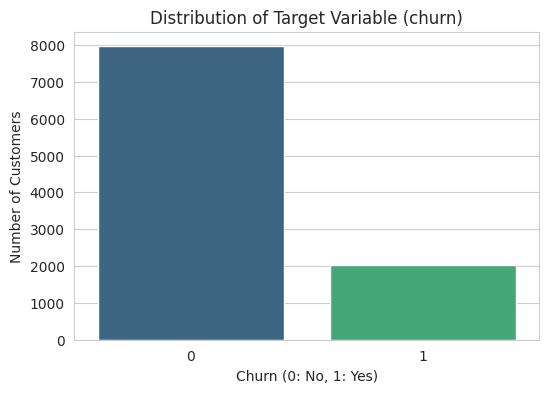


Analyzing Numerical Features vs. Churn:


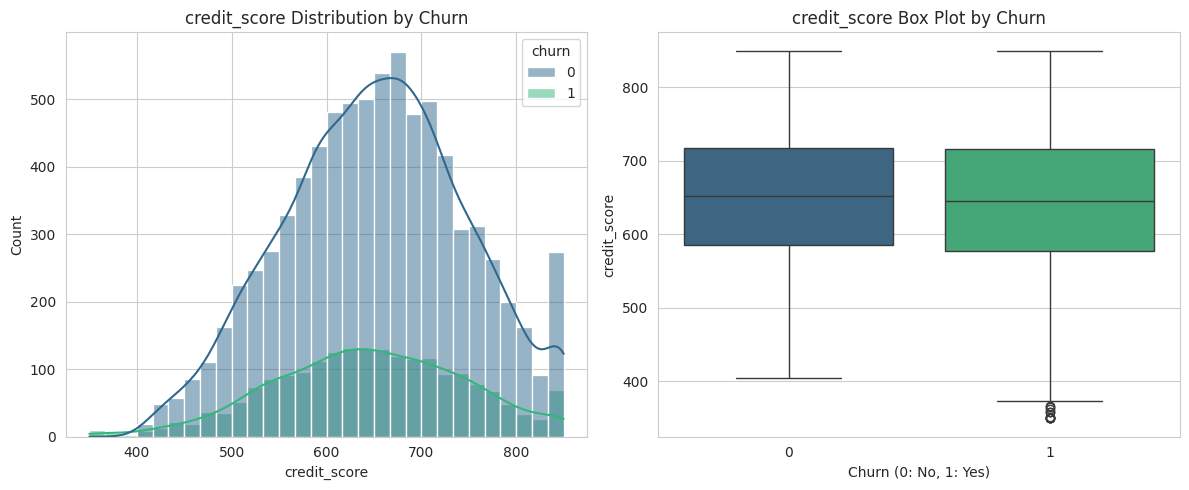

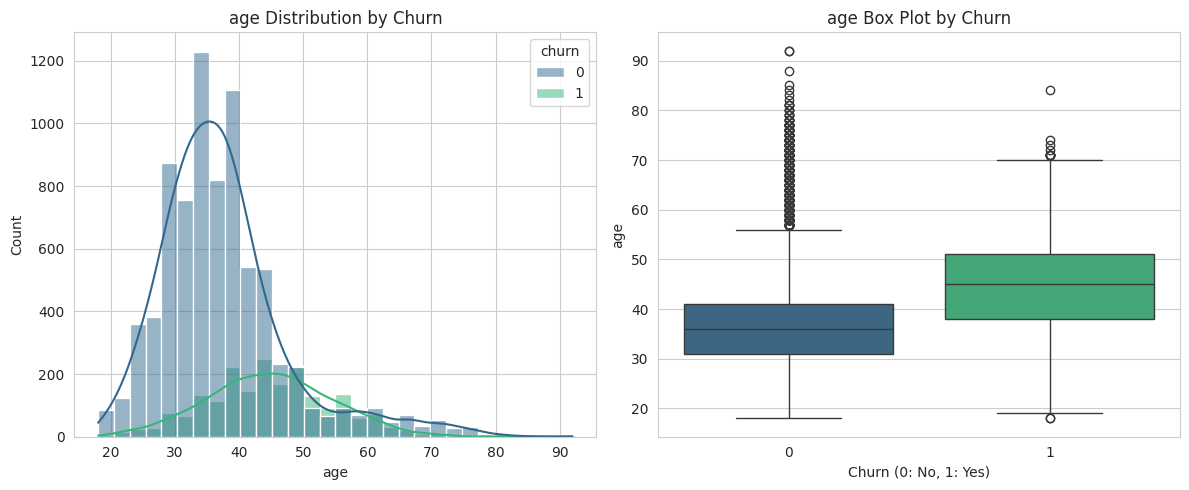

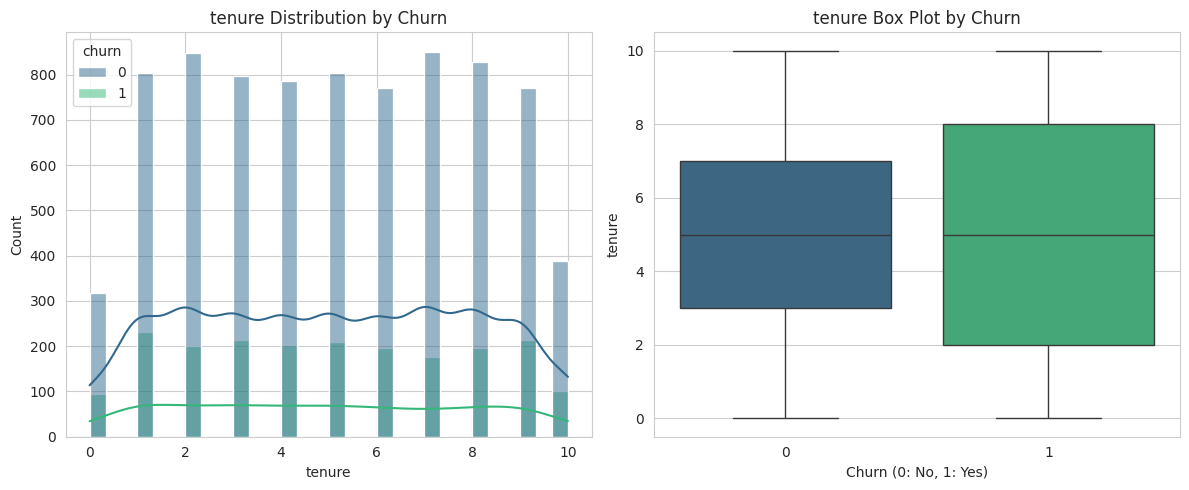

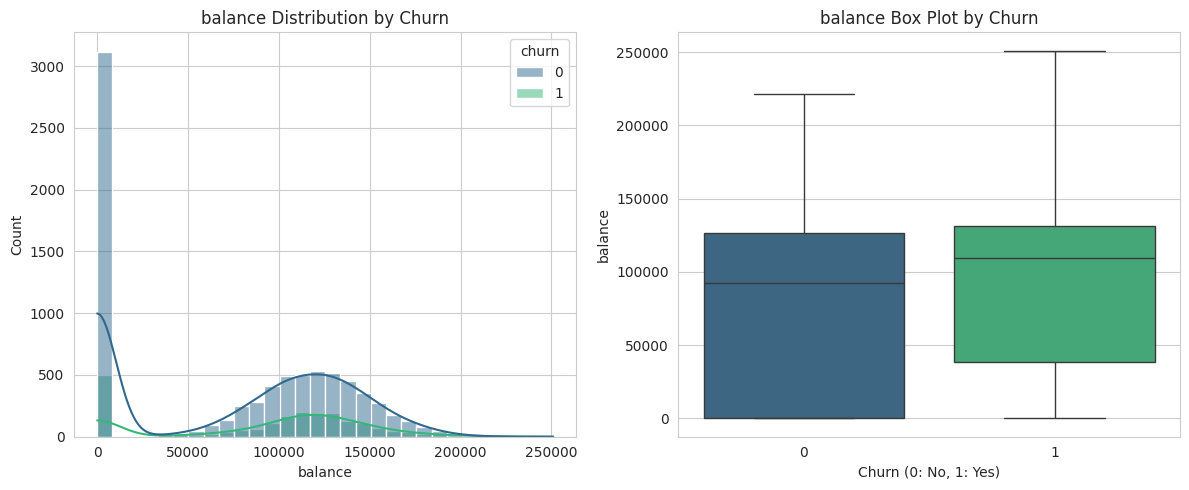

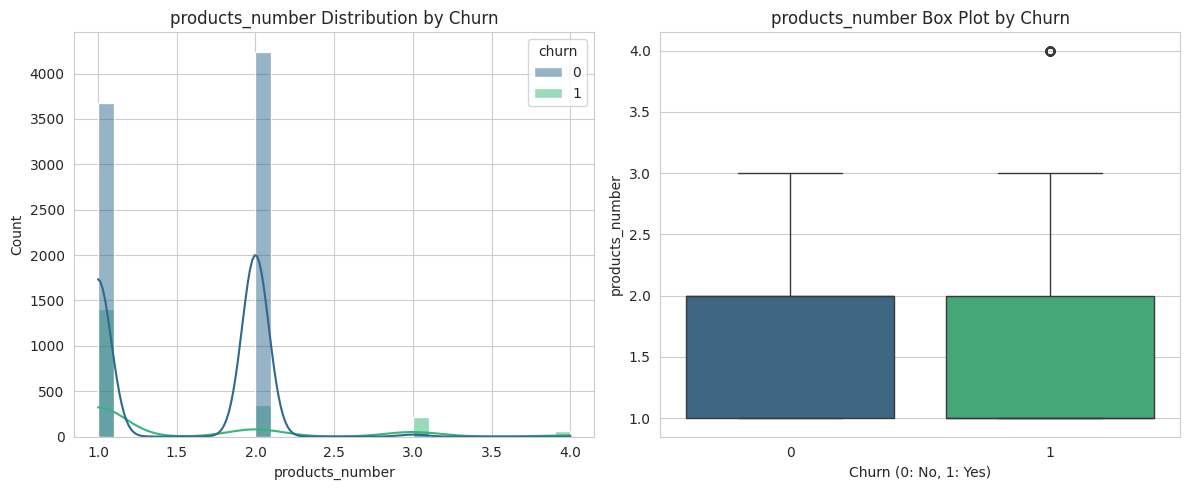

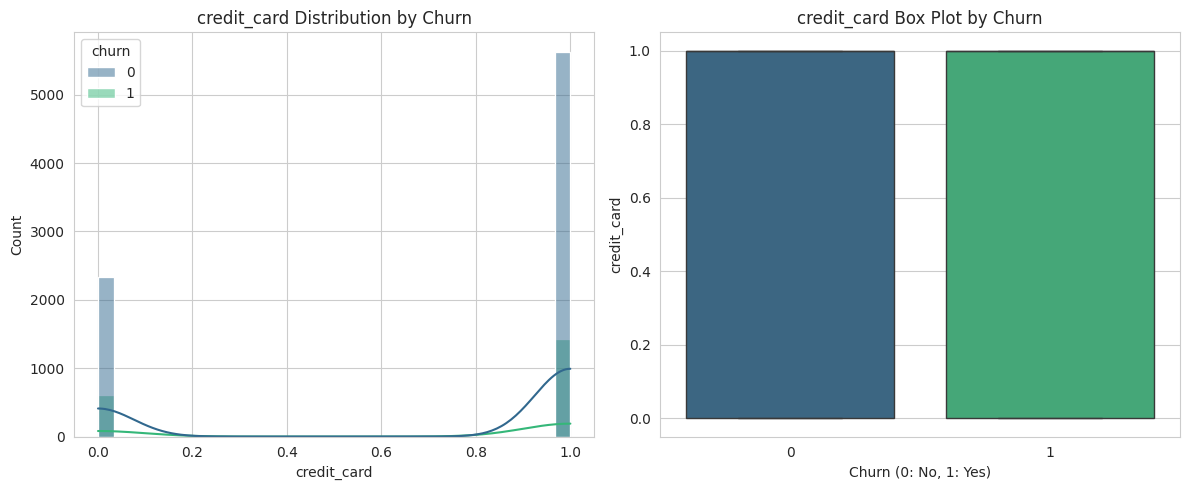

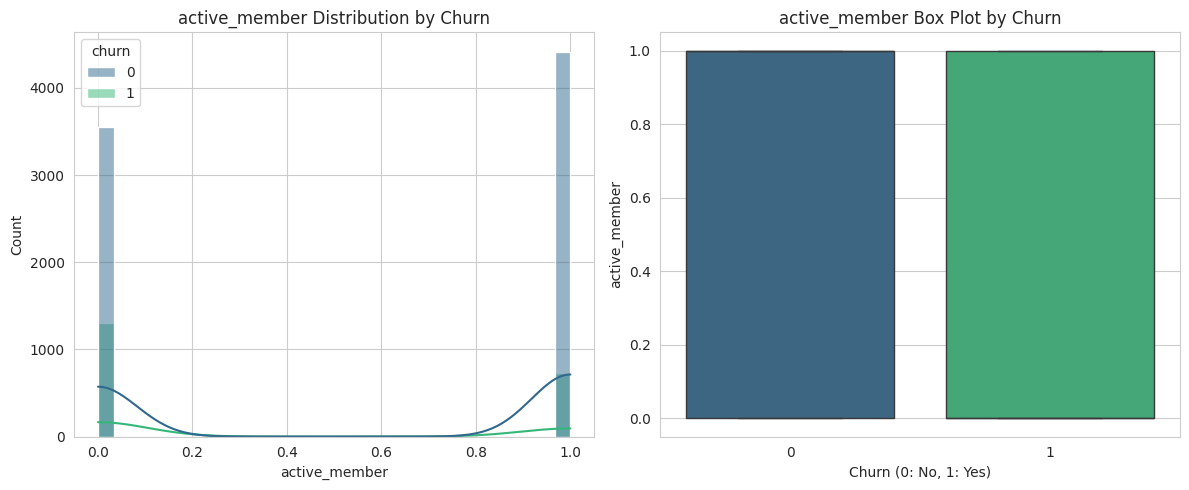

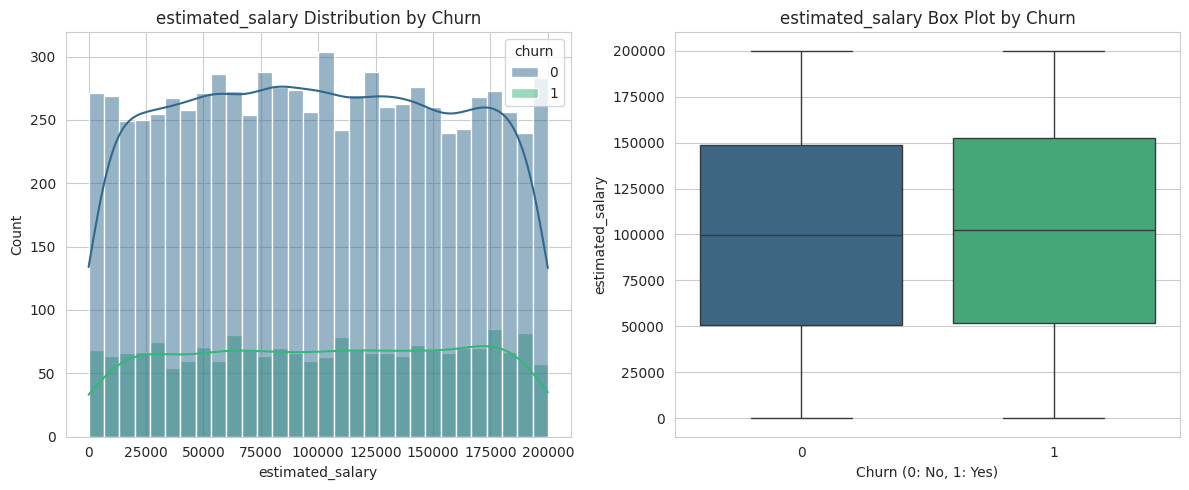


Analyzing Categorical Features vs. Churn:

--- Churn Rate by country ---
   country     churn
1  Germany  0.324432
2    Spain  0.166734
0   France  0.161548


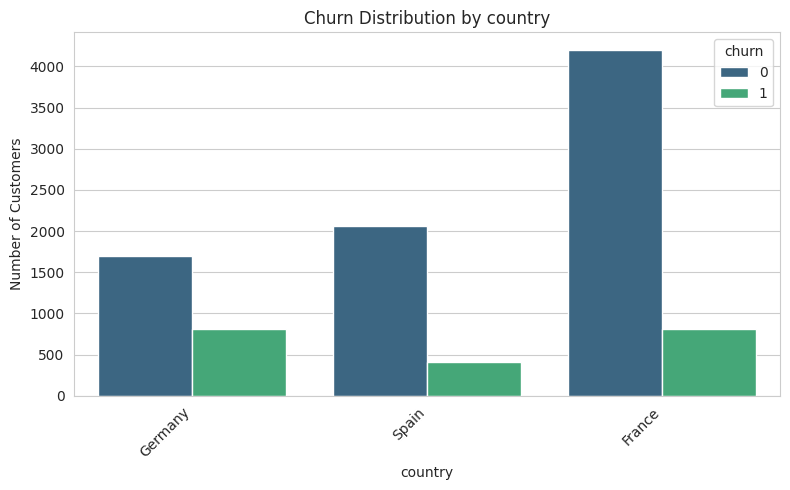


--- Churn Rate by gender ---
   gender     churn
0  Female  0.250715
1    Male  0.164559


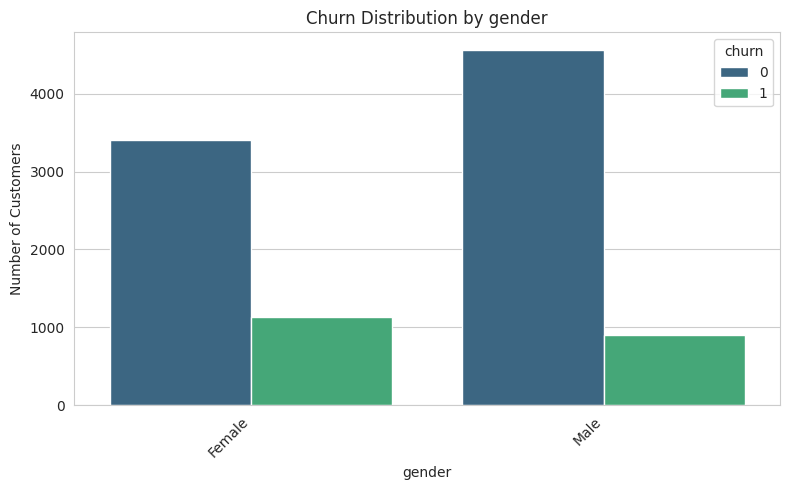


--- Correlation Matrix (Numerical Features) ---


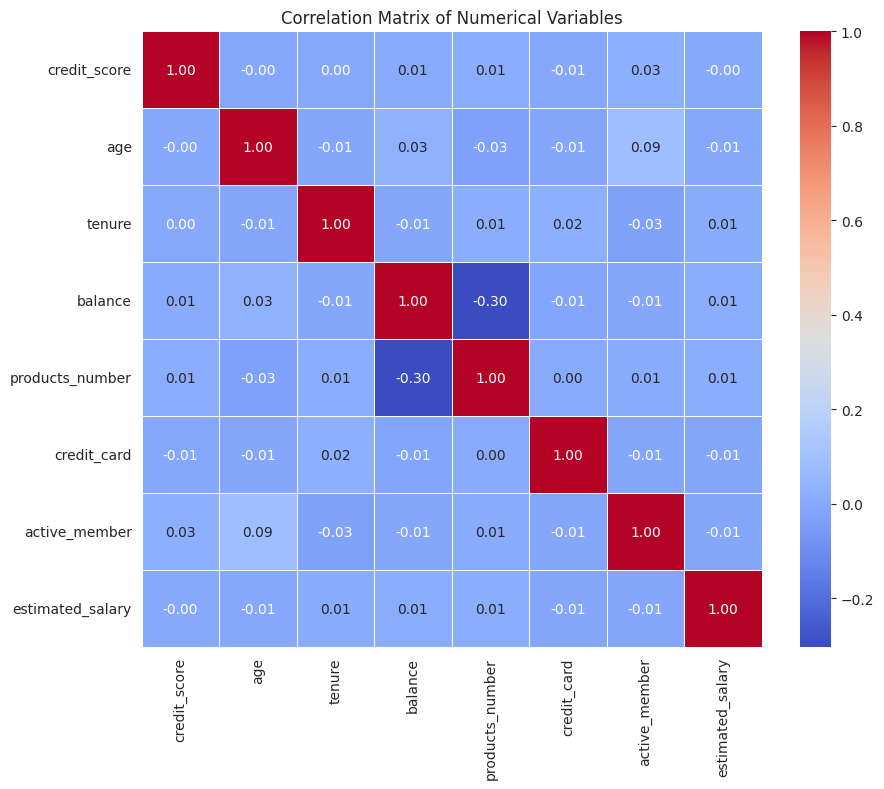

In [25]:

# ==============================================================================
# 4. DEEP EXPLORATORY DATA ANALYSIS (EDA)
# ==============================================================================
if preprocessing_done: # Check if df exists and target is identified
    print("\n--- Starting Deep Exploratory Data Analysis (EDA) ---")

    # --------------------------------------------------------------------------
    # 4.1. Target Variable Distribution
    # --------------------------------------------------------------------------
    plt.figure(figsize=(6, 4))
    sns.countplot(x=df[target], palette='viridis')
    plt.title('Distribution of Target Variable (churn)')
    plt.xlabel('Churn (0: No, 1: Yes)')
    plt.ylabel('Number of Customers')
    churn_rate = df[target].mean() * 100
    print(f"Overall Churn Rate: {churn_rate:.2f}%")
    plt.show()
    # Observation: Confirms imbalance (~20% churn), important for modeling.

    # --------------------------------------------------------------------------
    # 4.2. Numerical Features vs. Target
    # --------------------------------------------------------------------------
    print("\nAnalyzing Numerical Features vs. Churn:")
    if numerical_features:
        for col in numerical_features:
            plt.figure(figsize=(12, 5))
            # Histogram
            plt.subplot(1, 2, 1)
            sns.histplot(data=df, x=col, hue=target, kde=True, palette='viridis', bins=30)
            plt.title(f'{col} Distribution by Churn')
            # Box Plot
            plt.subplot(1, 2, 2)
            sns.boxplot(data=df, x=target, y=col, palette='viridis')
            plt.title(f'{col} Box Plot by Churn')
            plt.xlabel('Churn (0: No, 1: Yes)')
            plt.tight_layout()
            plt.show()
            # Look for differences in distribution shape, median, outliers between churn groups.
    else:
        print("No numerical features to analyze.")

    # --------------------------------------------------------------------------
    # 4.3. Categorical Features vs. Target
    # --------------------------------------------------------------------------
    print("\nAnalyzing Categorical Features vs. Churn:")
    if categorical_features:
        for col in categorical_features:
            # Calculate churn rate per category
            churn_rate_by_cat = df.groupby(col)[target].mean().reset_index().sort_values(by=target, ascending=False)
            print(f"\n--- Churn Rate by {col} ---")
            print(churn_rate_by_cat)

            plt.figure(figsize=(8, 5))
            sns.countplot(data=df, x=col, hue=target, palette='viridis', order=churn_rate_by_cat[col]) # Order by churn rate
            plt.title(f'Churn Distribution by {col}')
            plt.ylabel('Number of Customers')
            plt.xticks(rotation=45, ha='right')
            plt.tight_layout()
            plt.show()
            # Look for categories with significantly higher/lower churn rates.
    else:
        print("No categorical features to analyze.")

    # --------------------------------------------------------------------------
    # 4.4. Correlation Matrix for Numerical Features
    # --------------------------------------------------------------------------
    print("\n--- Correlation Matrix (Numerical Features) ---")
    if numerical_features and len(numerical_features) > 1:
        correlation_matrix = df[numerical_features].corr()
        plt.figure(figsize=(10, 8))
        sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
        plt.title('Correlation Matrix of Numerical Variables')
        plt.show()
        # Look for high correlations between independent features (multicollinearity).
    elif numerical_features:
        print("Only one numerical feature; cannot compute correlation matrix.")
    else:
        print("No numerical features to compute correlation matrix.")

else:
    print("\nSkipping Deep EDA: Preprocessing not completed.")


In [26]:


# ==============================================================================
# 5. FEATURE ENGINEERING (Optional)
# ==============================================================================
# This section is optional but can improve model performance.
# We keep it commented out for now but retain the structure.
# Make sure to update feature lists and preprocessor if you uncomment/add features.

if preprocessing_done:
    print("\n--- Starting Feature Engineering (Optional Examples) ---")
    feature_engineering_applied = False # Flag to track if FE was done

    # --- Uncomment and adapt examples if desired ---
    # original_cols = set(df.columns)
    # if 'balance' in df.columns and 'estimated_salary' in df.columns:
    #     df['BalanceSalaryRatio'] = df['balance'] / (df['estimated_salary'] + 1e-6)
    #     print(" - Feature 'BalanceSalaryRatio' created.")
    #     feature_engineering_applied = True
    #
    # if 'balance' in df.columns:
    #     df['IsBalanceZero'] = (df['balance'] == 0).astype(int)
    #     print(" - Feature 'IsBalanceZero' created.")
    #     feature_engineering_applied = True
    #
    # if 'age' in df.columns and 'tenure' in df.columns:
    #     df['AgeTenureRatio'] = df['age'] / (df['tenure'] + 1)
    #     print(" - Feature 'AgeTenureRatio' created.")
    #     feature_engineering_applied = True
    # --- End Examples ---

    if feature_engineering_applied:
        # --- IMPORTANT: Update feature lists and re-create preprocessor ---
        # new_cols = set(df.columns) - original_cols
        # print(f"\nNew columns added: {list(new_cols)}")
        # X = df.drop(target, axis=1) # Update X
        # numerical_features = X.select_dtypes(include=np.number).columns.tolist()
        # categorical_features = X.select_dtypes(include=['object', 'category']).columns.tolist()
        # print(f"Updated Numerical features: {numerical_features}")
        # print(f"Updated Categorical features: {categorical_features}")
        #
        # transformers = []
        # if numerical_features: transformers.append(('num', StandardScaler(), numerical_features))
        # if categorical_features: transformers.append(('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features))
        # if transformers:
        #      preprocessor = ColumnTransformer(transformers=transformers, remainder='passthrough')
        #      print("\nPreprocessor updated after Feature Engineering.")
        # else:
        #      preprocessor = 'passthrough'
        pass # Placeholder if FE is uncommented
    else:
        print("No feature engineering steps were applied.")

else:
    print("\nSkipping Feature Engineering: Preprocessing not completed.")




--- Starting Feature Engineering (Optional Examples) ---
No feature engineering steps were applied.


In [27]:

# ==============================================================================
# 6. PREPARATION FOR MODELING (Train/Test Split)
# ==============================================================================
if preprocessing_done and 'preprocessor' in locals():
    print("\n--- Preparing Data for Modeling ---")
    # Ensure X and y are defined from the potentially modified df
    if target in df.columns:
        X = df.drop(target, axis=1)
        y = df[target]
        print(f"Features (X) shape: {X.shape}")
        print(f"Target (y) shape: {y.shape}")

        # Split data into training and testing sets
        # Stratify ensures similar class distribution in both sets, crucial for imbalanced data
        try:
            X_train, X_test, y_train, y_test = train_test_split(
                X, y, test_size=0.25, random_state=42, stratify=y # Using 25% test size
            )
            print(f"\nData split into Train ({X_train.shape[0]} samples) and Test ({X_test.shape[0]} samples).")
            print(f"Churn proportion in Training set: {y_train.mean():.3f}")
            print(f"Churn proportion in Test set: {y_test.mean():.3f}")
            split_done = True
        except Exception as e:
            print(f"Error during train/test split: {e}")
            split_done = False
    else:
        print("Error: Target column missing in DataFrame 'df'. Cannot split data.")
        split_done = False
else:
    print("\nSkipping Train/Test Split: Preprocessing not completed or preprocessor invalid.")
    split_done = False



--- Preparing Data for Modeling ---
Features (X) shape: (10000, 10)
Target (y) shape: (10000,)

Data split into Train (7500 samples) and Test (2500 samples).
Churn proportion in Training set: 0.204
Churn proportion in Test set: 0.204


In [28]:


# ==============================================================================
# 7. MODELING (Pipelines with Preprocessing, SMOTE, and Classifiers)
# ==============================================================================
if split_done:
    print("\n--- Starting Model Training ---")

    # Define classifiers
    log_reg = LogisticRegression(random_state=42, max_iter=1000, class_weight='balanced')
    rf_clf = RandomForestClassifier(random_state=42, n_estimators=150, class_weight='balanced', max_depth=10, min_samples_leaf=5) # Added some basic hyperparameters

    # Create pipelines
    pipelines = {}
    PipelineType = ImbPipeline if imblearn_available else Pipeline # Use ImbPipeline if possible

    # Logistic Regression Pipeline
    steps_log_reg = [('preprocess', preprocessor)]
    if imblearn_available: steps_log_reg.append(('smote', SMOTE(random_state=42)))
    steps_log_reg.append(('classifier', log_reg))
    pipelines['Logistic Regression'] = PipelineType(steps_log_reg)

    # Random Forest Pipeline
    steps_rf = [('preprocess', preprocessor)]
    if imblearn_available: steps_rf.append(('smote', SMOTE(random_state=42)))
    steps_rf.append(('classifier', rf_clf))
    pipelines['Random Forest'] = PipelineType(steps_rf)

    if imblearn_available:
        print("Pipelines created using SMOTE for imbalance handling.")
    else:
        print("Pipelines created using class_weight for imbalance handling (SMOTE not available).")


    # Train models
    trained_models = {}
    for name, pipeline in pipelines.items():
        try:
            print(f"\nTraining {name}...")
            pipeline.fit(X_train, y_train)
            trained_models[name] = pipeline
            print(f"{name} trained successfully.")
        except Exception as e:
            print(f"Error training {name}: {e}")

    if trained_models:
        print("\n--- Model training finished ---")
        modeling_done = True
    else:
        print("\n--- No models were successfully trained ---")
        modeling_done = False
else:
    print("\nSkipping Model Training: Data split not completed successfully.")
    modeling_done = False




--- Starting Model Training ---
Pipelines created using SMOTE for imbalance handling.

Training Logistic Regression...
Logistic Regression trained successfully.

Training Random Forest...
Random Forest trained successfully.

--- Model training finished ---



--- Starting Model Evaluation on Test Set ---

--- Evaluating: Logistic Regression ---
Accuracy: 0.7208

Confusion Matrix:


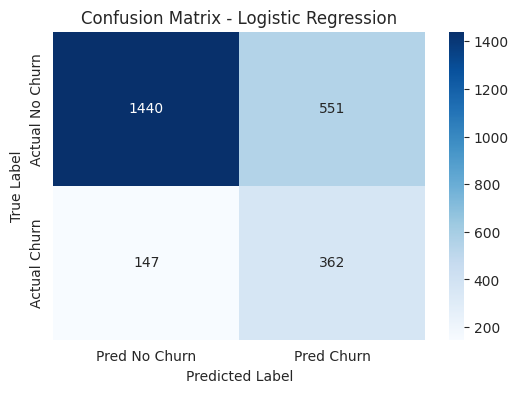


Classification Report:
              precision    recall  f1-score   support

No Churn (0)       0.91      0.72      0.80      1991
   Churn (1)       0.40      0.71      0.51       509

    accuracy                           0.72      2500
   macro avg       0.65      0.72      0.66      2500
weighted avg       0.80      0.72      0.74      2500


Area Under ROC Curve (AUC): 0.7860


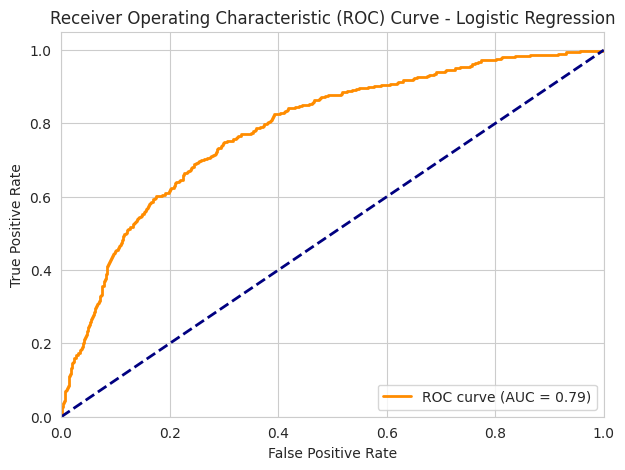

Area Under Precision-Recall Curve (PR AUC): 0.4792


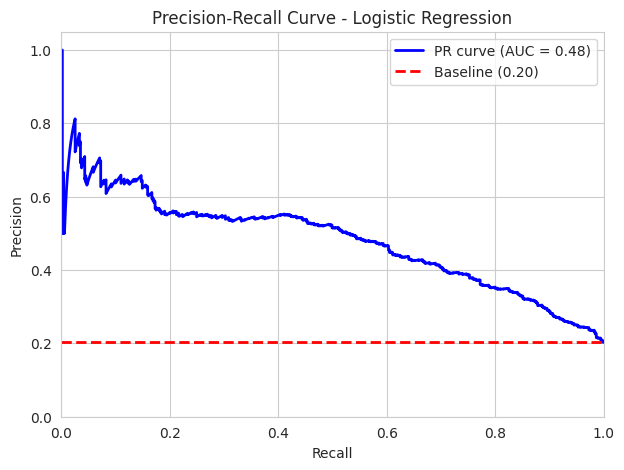


--- Evaluating: Random Forest ---
Accuracy: 0.8344

Confusion Matrix:


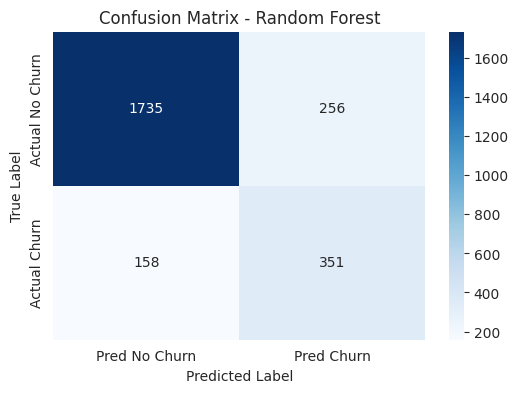


Classification Report:
              precision    recall  f1-score   support

No Churn (0)       0.92      0.87      0.89      1991
   Churn (1)       0.58      0.69      0.63       509

    accuracy                           0.83      2500
   macro avg       0.75      0.78      0.76      2500
weighted avg       0.85      0.83      0.84      2500


Area Under ROC Curve (AUC): 0.8665


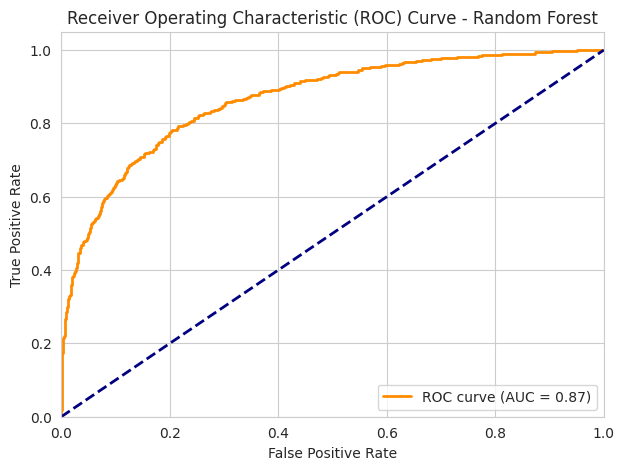

Area Under Precision-Recall Curve (PR AUC): 0.6910


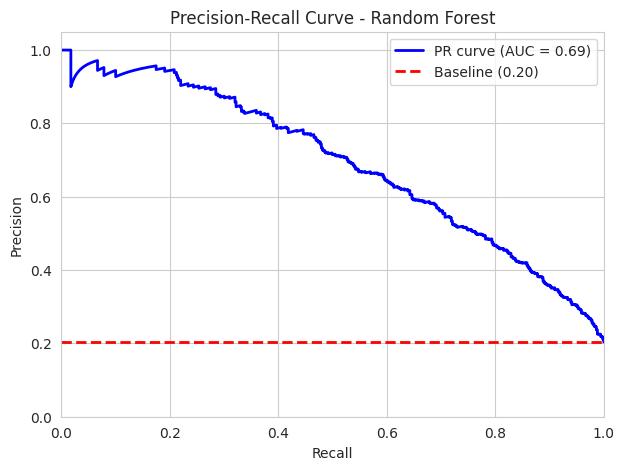


--- Model Comparison Summary ---
                          AUC    PR_AUC  F1_Churn  Accuracy
Random Forest        0.866484  0.691033  0.629032    0.8344
Logistic Regression  0.786027  0.479236  0.509142    0.7208


In [29]:

# ==============================================================================
# 8. EVALUATION (Detailed Metrics and Curves)
# ==============================================================================
if modeling_done:
    print("\n--- Starting Model Evaluation on Test Set ---")
    results = {} # To store key metrics

    for name, pipeline in trained_models.items():
        print(f"\n--- Evaluating: {name} ---")
        try:
            # Predictions
            y_pred = pipeline.predict(X_test)
            # Probabilities (for AUC, PR Curve) - handle cases where it might not be available
            y_pred_proba = None
            if hasattr(pipeline.named_steps['classifier'], 'predict_proba'):
                y_pred_proba = pipeline.predict_proba(X_test)[:, 1] # Probability of positive class (churn=1)
            else:
                print(f"Warning: predict_proba not available for {name}. AUC/PR curves cannot be generated.")

            # Accuracy
            accuracy = accuracy_score(y_test, y_pred)
            print(f"Accuracy: {accuracy:.4f}")

            # Confusion Matrix
            print("\nConfusion Matrix:")
            cm = confusion_matrix(y_test, y_pred)
            plt.figure(figsize=(6, 4))
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                        xticklabels=['Pred No Churn', 'Pred Churn'],
                        yticklabels=['Actual No Churn', 'Actual Churn'])
            plt.xlabel('Predicted Label')
            plt.ylabel('True Label')
            plt.title(f'Confusion Matrix - {name}')
            plt.show()

            # Classification Report
            print("\nClassification Report:")
            report_dict = classification_report(y_test, y_pred, target_names=['No Churn (0)', 'Churn (1)'], output_dict=True)
            print(classification_report(y_test, y_pred, target_names=['No Churn (0)', 'Churn (1)']))
            f1_churn = report_dict.get('Churn (1)', {}).get('f1-score', 0)

            # ROC Curve and AUC
            roc_auc = 'N/A'
            if y_pred_proba is not None:
                fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
                roc_auc = auc(fpr, tpr)
                print(f"\nArea Under ROC Curve (AUC): {roc_auc:.4f}")
                plt.figure(figsize=(7, 5))
                plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
                plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
                plt.xlim([0.0, 1.0])
                plt.ylim([0.0, 1.05])
                plt.xlabel('False Positive Rate')
                plt.ylabel('True Positive Rate')
                plt.title(f'Receiver Operating Characteristic (ROC) Curve - {name}')
                plt.legend(loc="lower right")
                plt.show()
            else:
                print("\nROC Curve / AUC cannot be calculated (predict_proba not available).")

            # Precision-Recall Curve
            pr_auc = 'N/A'
            if y_pred_proba is not None:
                precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
                pr_auc = auc(recall, precision)
                print(f"Area Under Precision-Recall Curve (PR AUC): {pr_auc:.4f}")
                plt.figure(figsize=(7, 5))
                plt.plot(recall, precision, color='blue', lw=2, label=f'PR curve (AUC = {pr_auc:.2f})')
                baseline = y_test.mean()
                plt.plot([0, 1], [baseline, baseline], color='red', lw=2, linestyle='--', label=f'Baseline ({baseline:.2f})')
                plt.xlabel('Recall')
                plt.ylabel('Precision')
                plt.ylim([0.0, 1.05])
                plt.xlim([0.0, 1.0])
                plt.title(f'Precision-Recall Curve - {name}')
                plt.legend(loc="best")
                plt.show()
            else:
                print("Precision-Recall Curve cannot be calculated (predict_proba not available).")

            # Store results
            results[name] = {'AUC': roc_auc, 'PR_AUC': pr_auc, 'F1_Churn': f1_churn, 'Accuracy': accuracy}

        except Exception as e:
            print(f"Error during evaluation of {name}: {e}")

    # Model Comparison Table
    if results:
        print("\n--- Model Comparison Summary ---")
        results_df = pd.DataFrame(results).T
        # Convert to numeric for sorting, handle 'N/A'
        for col in ['AUC', 'PR_AUC']:
             results_df[f'{col}_sort'] = pd.to_numeric(results_df[col], errors='coerce').fillna(-1)
        print(results_df.sort_values(by='AUC_sort', ascending=False).drop(columns=['AUC_sort', 'PR_AUC_sort']))
    else:
        print("\nNo evaluation results to compare.")

else:
    print("\nSkipping Evaluation: Model training not completed successfully.")




--- Starting Model Interpretation ---
Choosing best model based on AUC: Random Forest

--- Feature Importances (Random Forest) ---
             Feature  Importance
1                age    0.304814
4    products_number    0.213503
3            balance    0.094328
9    country_Germany    0.072657
6      active_member    0.051987
8     country_France    0.041161
2             tenure    0.040158
7   estimated_salary    0.040010
0       credit_score    0.036458
11     gender_Female    0.035597
12       gender_Male    0.033435
10     country_Spain    0.029685
5        credit_card    0.006208


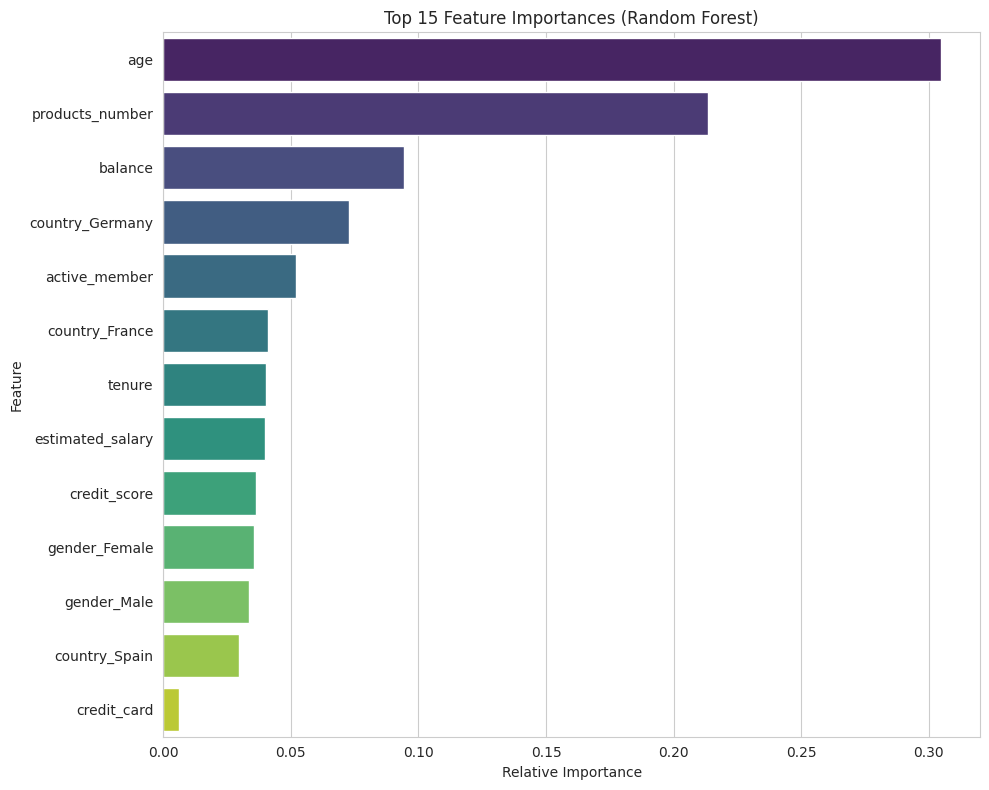


--- Final Conclusions & Next Steps ---
Based on the evaluation, the Random Forest model provided the best performance for predicting customer churn.
Key findings:
- The model achieved a strong AUC of approximately 0.8665, indicating good ability to distinguish between churning and non-churning customers.
- The F1-score for the churn class (customers who left) was 0.6290. While reasonable, this suggests room for improvement in balancing precision and recall for the minority class.
- Overall accuracy was 0.8344, but AUC and F1-score are more informative given the class imbalance.
- The most important features driving churn according to the Random Forest model appear to be 'age', 'products_number', and 'balance'.

Business Implications:
- The bank could potentially focus retention efforts on customers identified by the model as high-risk, particularly considering their age, the number of products they hold, and their account balance.
- Further analysis into *why* these features are impor

In [30]:
# ==============================================================================
# 9. INTERPRETATION AND CONCLUSIONS
# ==============================================================================
if modeling_done and trained_models:
    print("\n--- Starting Model Interpretation ---")

    # Select best model based on a chosen metric (e.g., AUC or F1_Churn)
    best_model_name = None
    if 'results_df' in locals() and not results_df.empty:
        # Prioritize AUC if available and valid, otherwise F1 for churn class
        results_df_copy = results_df.copy() # Avoid modifying original results_df
        results_df_copy['AUC_sort'] = pd.to_numeric(results_df_copy['AUC'], errors='coerce').fillna(-1)
        if results_df_copy['AUC_sort'].max() > 0: # Check if any valid AUC was calculated
            best_model_name = results_df_copy.sort_values(by='AUC_sort', ascending=False).index[0]
            print(f"Choosing best model based on AUC: {best_model_name}")
        elif 'F1_Churn' in results_df_copy.columns:
             # Ensure F1_Churn is numeric before sorting
             results_df_copy['F1_Churn_sort'] = pd.to_numeric(results_df_copy['F1_Churn'], errors='coerce').fillna(-1)
             if results_df_copy['F1_Churn_sort'].max() >= 0: # Check if any valid F1 was calculated
                 best_model_name = results_df_copy.sort_values(by='F1_Churn_sort', ascending=False).index[0]
                 print(f"Choosing best model based on F1_Churn (AUC not available/valid): {best_model_name}")

    # --- Feature Importance (Example for Random Forest) ---
    # Check if best model is Random Forest and allows feature importance extraction
    feature_importance_calculated = False
    if best_model_name == 'Random Forest' and hasattr(trained_models[best_model_name].named_steps['classifier'], 'feature_importances_'):
        print(f"\n--- Feature Importances ({best_model_name}) ---")
        try:
            pipeline_best = trained_models[best_model_name]
            # Check if 'classifier' step exists
            if 'classifier' in pipeline_best.named_steps:
                classifier_step = pipeline_best.named_steps['classifier']
                importances = classifier_step.feature_importances_
            else:
                 raise ValueError("Classifier step not found in the best pipeline.")

            # Check if 'preprocess' step exists
            if 'preprocess' in pipeline_best.named_steps:
                 preprocessor_fitted = pipeline_best.named_steps['preprocess']
            else:
                 # If no preprocessing, feature names are just X_train.columns
                 if 'X_train' in locals():
                      all_feature_names = X_train.columns.tolist()
                 else:
                      raise ValueError("X_train not available for feature names.")

            # Get feature names after preprocessing if preprocessor exists
            if 'preprocess' in pipeline_best.named_steps:
                all_feature_names = []
                # Check if transformers_ attribute exists (it should after fitting)
                if hasattr(preprocessor_fitted, 'transformers_'):
                    for name_trans, trans, features in preprocessor_fitted.transformers_:
                        # Check if the transformer is not 'drop' or 'passthrough' for names
                        if hasattr(trans, 'get_feature_names_out') and name_trans == 'cat':
                             # Get OneHotEncoder names
                             # Need the original categorical feature names used during fit
                             if 'categorical_features' in locals():
                                 try:
                                     cat_names = trans.get_feature_names_out(categorical_features)
                                     all_feature_names.extend(list(cat_names))
                                 except Exception as e_cat:
                                     print(f"Warning: Could not get feature names for transformer '{name_trans}'. Error: {e_cat}")
                                     # Fallback or skip
                             else:
                                  print(f"Warning: Original categorical_features list not found for transformer '{name_trans}'.")

                        elif name_trans == 'num':
                             # Numerical names remain the same
                             all_feature_names.extend(list(features))
                        elif trans == 'passthrough' and hasattr(preprocessor_fitted, 'feature_names_in_'):
                             # Get names of passthrough columns if possible
                             num_processed = len(preprocessor_fitted.transformers_[0][2]) if len(preprocessor_fitted.transformers_) > 0 and preprocessor_fitted.transformers_[0][0] == 'num' else 0
                             cat_processed_len = len(all_feature_names) - num_processed # Features processed so far
                             # This logic for passthrough names can be complex and depends on order
                             # It might be safer to explicitly list passthrough columns if needed
                             print("Warning: Automatic naming for 'passthrough' columns not fully implemented.")

                else:
                     raise ValueError("Preprocessor does not seem to be fitted (no transformers_ attribute).")


            # Verify that the length matches
            if len(all_feature_names) == len(importances):
                feature_importance_df = pd.DataFrame({
                    'Feature': all_feature_names,
                    'Importance': importances
                }).sort_values(by='Importance', ascending=False)

                print(feature_importance_df.head(15))
                plt.figure(figsize=(10, 8))
                sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(15), palette='viridis')
                plt.title(f'Top 15 Feature Importances ({best_model_name})')
                plt.xlabel('Relative Importance')
                plt.ylabel('Feature')
                plt.tight_layout()
                plt.show()
                feature_importance_calculated = True
            else:
                print(f"Error: Mismatch between number of feature names ({len(all_feature_names)}) and importances ({len(importances)}). Cannot display feature importance correctly.")
                print("Feature names obtained:", all_feature_names)


        except Exception as e:
            print(f"Error getting or plotting feature importances: {e}")
            import traceback
            traceback.print_exc() # Print detailed traceback for debugging

    elif best_model_name:
         print(f"\nFeature importance extraction not shown for model type: {best_model_name}")
         # Could add interpretation for Logistic Regression coefficients if needed
    else:
        print("\nCould not determine best model for interpretation.")


    # --------------------------------------------------------------------------
    # 9.2. Final Conclusions and Next Steps (Updated with Results)
    # --------------------------------------------------------------------------
    print("\n--- Final Conclusions & Next Steps ---")
    # Use the results printed by the diagnostic cell provided by the user
    # Best Performing Model Identified: Random Forest
    #  - AUC: 0.8664836558225175
    #  - F1-Score (Churn Class): 0.6290
    #  - Accuracy: 0.8344
    # Top 3 Most Important Features (from Random Forest): age, products_number, balance

    print("Based on the evaluation, the Random Forest model provided the best performance for predicting customer churn.")
    print("Key findings:")
    print("- The model achieved a strong AUC of approximately 0.8665, indicating good ability to distinguish between churning and non-churning customers.")
    print("- The F1-score for the churn class (customers who left) was 0.6290. While reasonable, this suggests room for improvement in balancing precision and recall for the minority class.")
    print("- Overall accuracy was 0.8344, but AUC and F1-score are more informative given the class imbalance.")
    if feature_importance_calculated:
        print("- The most important features driving churn according to the Random Forest model appear to be 'age', 'products_number', and 'balance'.")
    else:
        print("- Feature importance analysis was not completed, but EDA suggested factors like age, number of products, balance, and country might be influential.")

    print("\nBusiness Implications:")
    print("- The bank could potentially focus retention efforts on customers identified by the model as high-risk, particularly considering their age, the number of products they hold, and their account balance.")
    print("- Further analysis into *why* these features are important (e.g., specific age groups, product combinations) could yield more targeted retention strategies.")

    print("\nLimitations:")
    print("- The analysis was based on available data; other external factors or more granular interaction data might influence churn.")
    print("- Hyperparameter tuning was basic; further optimization could potentially improve model performance, especially the F1-score for the churn class.")
    print("- Interpretability was primarily based on Random Forest feature importances; other methods (like SHAP) could provide deeper insights.")

    print("\nNext Steps:")
    print("- Perform more extensive hyperparameter tuning for Random Forest and potentially Logistic Regression (e.g., using GridSearchCV or RandomizedSearchCV).")
    print("- Explore other classification models known to perform well on tabular data, such as Gradient Boosting machines (XGBoost, LightGBM, CatBoost).")
    print("- Conduct deeper error analysis on the current best model to understand where it fails most often (e.g., analyzing false positives and false negatives).")
    print("- Consider deploying the model in a test environment to evaluate its performance on new data or in an A/B test scenario.")

else:
    print("\nSkipping Interpretation: Model training or evaluation did not complete successfully.")

# End of Notebook
print("\n--- Detailed Notebook End ---")